# Homework 3

For this homework, you will be working extensively in tensorflow. It is suggested that you spin up a Google Cloud VM with a GPU attached. Remember, instructions for doing so are found in Homework 0.

### Part 1: Homework 2, but on tensorflow
### Part 2: DNN on MNIST and CIFAR10
### Part 3: VGG on MNIST and CIFAR10
### (Optional) Part 4, getting state of the art (#SOTA)


# Part 1
You don't have to repeat everything in homework 2, but rather pick one set of two features that worked well for you last homework, and implement logistic regression using tensorflow without using keras (you will practice using keras in parts 2 and 3). In other words, using tensorflow operations, please create a scalar-value loss function and let tensorflow create the training operation for logistic regression, which automatically computes the gradients and updates the weight parameters. Note that the logistic loss is a special case of the softmax cross entropy loss that you've seen when classifying MNIST.

In [1]:
# Import datasets

%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.linalg import norm

digits = datasets.load_digits()

number_a = 6
number_b = 9

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)

# Extract training and testing sets 
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

In [2]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        top = np.sum(image[0:3, :])

        return top

    def compute_feature_b(image):
        bottom = np.sum(image[4:7, :])

        return bottom
    
    return compute_feature_a(image), compute_feature_b(image)

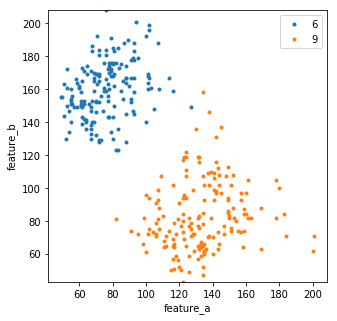

In [3]:
# Apply and plot features

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.legend([str(number_a), str(number_b)])
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 
plt.show()

In [4]:
def visualize_model(features_a, features_b, features, labels, weights, t=0):
    
    if weights.shape[0] == 2:
        bound_x = (t-weights[1]*features[:,1])/(weights[0]+0.000001)
    else: bound_x = (t-weights[2]*features[:,1] - weights[0])/(weights[1]+0.000001)
    bound = np.c_[bound_x, features[:, 1]]
    
    plt.figure()
    plt.plot(features_a[:, 0], features_a[:, 1], '.')
    plt.plot(features_b[:, 0], features_b[:, 1], '.')
    plt.legend([str(number_b), str(number_a)])
    plt.plot(bound[:, 0], bound[:, 1])
    plt.xlabel('feature_a')
    plt.ylabel('feature_b')
    plt.ylim(features[:, 1].min(), features[:, 1].max()) 
    plt.show()
    return None

In [5]:
y_train_arr = y_train.reshape([y_train.shape[0],1])
logistic_y = np.copy(y_train_arr)
logistic_y[y_train == number_a] = 0
logistic_y[y_train == number_b] = 1

y_test_arr = y_test.reshape([y_test.shape[0],1])
logistic_y_test = np.copy(y_test_arr)
logistic_y_test[y_test == number_a] = 0
logistic_y_test[y_test == number_b] = 1

In [6]:
import tensorflow as tf
# Concat a row of one to feature vector to account for the bias
X_features = np.c_[np.ones((X_features.shape[0], 1)), X_features]
X_features_test = np.c_[np.ones((X_features_test.shape[0], 1)), X_features_test]

# Create vars
feature = tf.placeholder(dtype=tf.float32, shape=(None,X_features.shape[1]), name='X_feature')
label = tf.placeholder(dtype=tf.int32, shape=(None,1), name='y')
w = tf.get_variable(name='weight', dtype=tf.float32, shape=(X_features.shape[1],1), initializer=tf.random_normal_initializer)

In [7]:
# Create operations
y_pred = tf.matmul(feature, w)
loss = tf.losses.sigmoid_cross_entropy(label, y_pred)

t_op = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(loss)

39.62321
0.0047721495
0.004771362
0.0047705886
0.004769826
0.0047690757
0.0047683427
0.0047675944
0.004766881
0.004766177
1.0


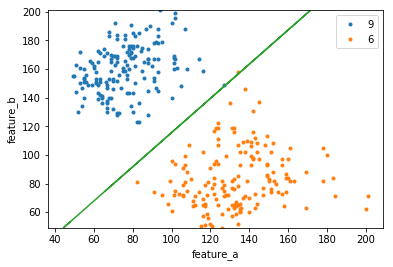

In [8]:
from sklearn.metrics import accuracy_score

# Start a session and initialize vars
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Start training. First, choose number of iterations
ITERATION = 2000
for i in range(ITERATION):
    sess.run(t_op, feed_dict={feature:X_features, label:logistic_y})
    if i % (ITERATION/10) == 0:
        print(sess.run(loss, feed_dict={feature:X_features, label:logistic_y}))
#     print(sess.run(label, feed_dict={label:logistic_y}), sess.run(y_pred, feed_dict={feature:X_features}))

pred = sess.run(y_pred, feed_dict={feature:X_features_test})
t=0.5
pred[pred<t] = 0
pred[pred>t] = 1
print(accuracy_score(logistic_y_test, pred))

w_b = np.ones([3,])
w_pred = sess.run(w)
wcopy = np.copy(w_b)
wcopy[0] = w_pred[0]
wcopy[1] = w_pred[1]
wcopy[2] = w_pred[2]

# X_features_a = X_features_test[np.where(y_test==number_a)]
# X_features_b = X_features_test[np.where(y_test==number_b)]
visualize_model(X_features_a, X_features_b, X_features, y_train, wcopy, t=0.5)

sess.close()

# Part 2:  DNN on MNIST and CIFAR10

In our lab, you guys saw how to work with the MNIST dataset to perform image classification. We can attempt the MNIST classification problem with just fully connected layers. This means we will be optimizing for non-banded matrices (no convolutions).

1. Calcualte the number of weight parameters you are optimizing for 1, 2 and 3 differen fully connected layers (the total size of each layer is up to you).
2. What is the max layer depth you can go before training loss does not converge? You can usually tell that something is not converging by examining the training loss vs. iteration curve.
3. How does the number of parameters relate to the training loss and validation/test loss? Try to get a few data points to speak to this question.
3. Keeping the maximum number of parameters possible while still maintaining convergence (i.e., a good training and validation/test loss), what happens when you swap the activation function to `tanh` instead of `relu`? How about `sigmoid`?
4. After exploring the above, train a DNN model with the combination of hyperparameters that you believe will work best on MNIST.
5. Using the same architecture, try training a DNN model on more difficult dataset such as Fashion MNIST or CIFAR10/100. Example download instructions are shown in the next problem.

### Must haves
1. Make a curve of the final validation/test loss of your DNN after the loss plateaus as a function of the number of weight parameters used (final loss versus # parameters used). Note that you might see something like the curve below for a low number of parameters, but as the number of parameters increases, it will not look like this plot. 
2. On the same figure, make the same curve as above, but use different activation functions in your architecture.
3. Plot a point corresponding to your crafted DNN archiecture for question 4.
4. Repeat 1-3 for CIFAR10

The curves when reasonable # params are used look like the below
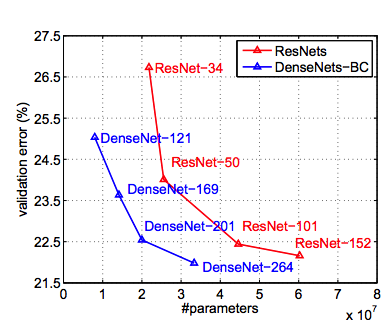

Using TensorFlow backend.


Training data shape (60000, 28, 28, 1)


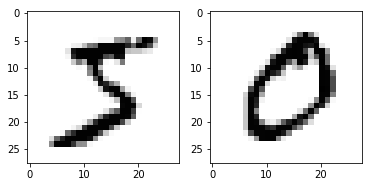

In [1]:
# MNIST

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
import matplotlib.pyplot as plt
import gc
import numpy as np

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

# Define function to return params count and minimum validation loss for each n_layer
def params_valloss(n_layers, weights_layer=100, epoch=10, verbose=0, early_stop=False, activation='relu',
                  input_shape=(28, 28, 1), lr=0.001):
    params_count, min_val_loss = [], []
    for i in range(1, n_layers+1):
        # Build your DNN, an example model is given for you.
        if early_stop:
            es = EarlyStopping(restore_best_weights=True)
        model = Sequential()
        model.add(Flatten(input_shape=input_shape))

            # Try adding more layers and graph the final loss and accuracy
        for j in range(i):
            model.add(Dense(weights_layer, activation=activation))
        model.add(Dense(10, activation='softmax'))

        model.compile(optimizer=tf.train.AdamOptimizer(lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()
        # Count param
        params_count.append(model.count_params())
        
        if early_stop:
            hist = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=epoch,
                  verbose=verbose,
                  callbacks=[es],
                  validation_data=(X_val, y_val))
        else: 
            hist = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=epoch,
                  verbose=verbose,
                  validation_data=(X_val, y_val))

        curr_l = hist.history['val_loss']
        min_val_loss.append(curr_l[-1])
        
        del model
        clear_session()  # Clear previous model
        gc.collect()
    return params_count, min_val_loss

In [13]:
# Part 2.1
n_layers = 3
params_count, _ = params_valloss(n_layers, epoch=1, weights_layer=50)  # Calculate # of params

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_

In [14]:
# Print numbers of parameters
for i in range(len(params_count)):
    print('Number of parameters for ' + str(i+1) + ' layer(s): ' + str(params_count[i]))

Number of parameters for 1 layer(s): 39760
Number of parameters for 2 layer(s): 42310
Number of parameters for 3 layer(s): 44860


In [11]:
# Part 2.2
n_layers = 10
epoch = 10

# Get val_loss vs #params results for three types of activation. Early-stop is used to choose the optimal iteration for each 
# training, making sure that all the training have converged
params_count_tanh, min_val_tanh = params_valloss(n_layers, epoch=epoch, verbose=0, weights_layer=100, activation='tanh', 
                                                 early_stop=True)
params_count, min_val_loss = params_valloss(n_layers, epoch=epoch, verbose=0, weights_layer=100, early_stop=True)
params_count_sig, min_val_sig = params_valloss(n_layers, epoch=epoch, verbose=0, weights_layer=100, activation='sigmoid', 
                                               early_stop=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
__________

In [16]:
import numpy as np

# Get minimum val loss and corresponded #param, indicating best model
min_val = min([min(min_val_loss), min(min_val_tanh), min(min_val_sig)])
if np.where(min_val_tanh==min_val)[0]:
    min_params = params_count_tanh[np.asscalar(np.where(min_val_tanh==min_val)[0])]
elif np.where(min_val_loss==min_val)[0]:
    min_params = params_count[np.asscalar(np.where(min_val_loss==min_val)[0])]
elif np.where(min_val_sig==min_val)[0]:
    min_params = params_count_sig[np.asscalar(np.where(min_val_sig==min_val)[0])]
    
print('Best val_loss: ' + str(min_val) + ' at ' + str(min_params) + ' params')

Best val_loss: 0.12849667707253248 at 160310 params


C:\Users\Tri Vu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


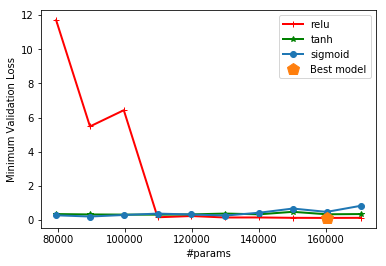

In [19]:
# Print out results
plt.plot(params_count, min_val_loss, "r-+", linewidth=2)
plt.plot(params_count, min_val_tanh, "g-*", linewidth=2)
plt.plot(params_count_sig, min_val_sig, "o-", linewidth=2)
plt.plot(min_params, min_val, "p", markersize=12)
plt.legend(['relu', 'tanh', 'sigmoid', 'Best model'])
plt.xlabel('#params')
plt.ylabel('Minimum Validation Loss')
plt.show()

###### On both training data, ReLU has the best performance. Sigmoid and tanh have good starting points but overfit faster with more parameters

### Examination on CIFAR-10

Training data shape (50000, 32, 32, 3)


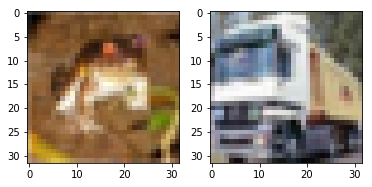

In [2]:
# CIFAR-10

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(32, 32, 3));
ax2.imshow(X_train[1].reshape(32, 32, 3));

In [3]:
n_layers = 10
epoch = 10

# Get val_loss vs #params results for three types of activation. Early-stop is used to choose the optimal iteration for each 
# training, making sure that all the training have converged
params_count, min_val_loss = params_valloss(n_layers, epoch=epoch, verbose=0, weights_layer=100, early_stop=False,
                                           input_shape=(32, 32, 3), lr=1e-4)
params_count_tanh, min_val_tanh = params_valloss(n_layers, epoch=epoch, verbose=0, weights_layer=100, activation='tanh', 
                                                 early_stop=False, input_shape=(32, 32, 3), lr=1e-5)
params_count_sig, min_val_sig = params_valloss(n_layers, epoch=epoch, verbose=0, weights_layer=100, activation='sigmoid', 
                                               early_stop=False, input_shape=(32, 32, 3), lr=1e-5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 308,310
Trainable params: 308,310
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dens

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 308,310
Trainable params: 308,310
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dens

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
__________

In [4]:
import numpy as np
# Get minimum val loss
min_val = min([min(min_val_loss), min(min_val_tanh), min(min_val_sig)])
if np.where(min_val_tanh==min_val)[0]:
    min_params = params_count_tanh[np.asscalar(np.where(min_val_tanh==min_val)[0])]
elif np.where(min_val_loss==min_val)[0]:
    min_params = params_count[np.asscalar(np.where(min_val_loss==min_val)[0])]
elif np.where(min_val_sig==min_val)[0]:
    min_params = params_count_sig[np.asscalar(np.where(min_val_sig==min_val)[0])]
    
print('Best val_loss: ' + str(min_val) + ' at ' + str(min_params))

Best val_loss: 1.5683327753067016 at 399210


C:\Users\Tri Vu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.


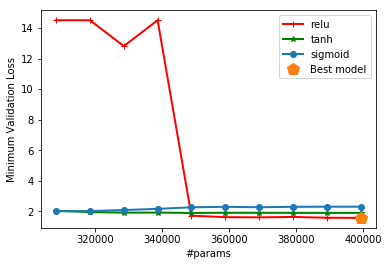

In [5]:
plt.plot(params_count, min_val_loss, "r-+", linewidth=2)
plt.plot(params_count, min_val_tanh, "g-*", linewidth=2)
plt.plot(params_count_sig, min_val_sig, "o-", linewidth=2)
plt.plot(min_params, min_val, "p", markersize=12)
plt.legend(['relu', 'tanh', 'sigmoid', 'Best model'])
plt.xlabel('#params')
plt.ylabel('Minimum Validation Loss')
plt.show()

# Part 3. VGG on CIFAR100 and CIFAR10

VGG is a simple, but powerful CNN created in 2015. Read the VGG paper here: https://arxiv.org/pdf/1409.1556.pdf

Here, we're going to try to reproduce the model's findings on the cifar10 and cifar100 dataset. Note that the paper takes 224 x 224 images, but cifar10 and 100 are only 32 x 32 images.

1. Implement all of the layers for the VGG ConvNet Configuration A. Please use the shell code below as guide. Then, train this network on the Cifar10 and Cifar100 datasets.
2. For Cifar10 and 100, VGG is probably overkill. Try changing the number of layers and number of filters without sacrificing too much performance accuracy. How many filters can you get rid of before you see the accuracy drop by more than 2%? Where in the architecture is it better to remove filters - towards the input layers, or more towards the output layers?
3. For what you experiment with--report the parameter, validation loss curves for changing the number of i) layers, ii) filter size, iii) both.

Training data shape (50000, 32, 32, 3)


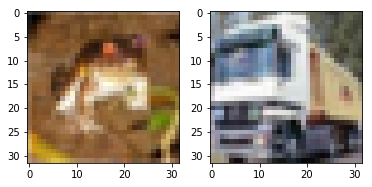

In [3]:
# This is the same model in the other notebook, looks very simplified.
import tensorflow as tf
(X_train10, y_train10), (X_val10, y_val10) = tf.keras.datasets.cifar10.load_data()
y_train10 = tf.keras.utils.to_categorical(y_train10, 10)
y_val10 = tf.keras.utils.to_categorical(y_val10, 10)

X_train10 = X_train10.reshape(X_train10.shape[0], 32, 32, 3)
X_val10 = X_val10.reshape(X_val10.shape[0], 32, 32, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train10.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train10[0].reshape(32, 32, 3));
ax2.imshow(X_train10[1].reshape(32, 32, 3));

In [3]:
import numpy as np
model10 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model10.compile(optimizer=tf.train.AdamOptimizer(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model10.summary()
hist = model10.fit(X_train10, y_train10,
                  batch_size=64,
                  epochs=50,
                  verbose=1,
                  validation_data=(X_val10, y_val10))

del model10
clear_session()  # Clear previous model
gc.collect()
tf.reset_default_graph()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
__________

Epoch 41/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0336 - acc: 0.9896 - val_loss: 1.5969 - val_acc: 0.7462
Epoch 42/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0269 - acc: 0.9916 - val_loss: 1.4288 - val_acc: 0.7419
Epoch 43/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0289 - acc: 0.9907 - val_loss: 1.6455 - val_acc: 0.7374
Epoch 44/50
50000/50000 [==============================] - 23s 466us/step - loss: 0.0277 - acc: 0.9910 - val_loss: 1.5884 - val_acc: 0.7493
Epoch 45/50
50000/50000 [==============================] - 23s 467us/step - loss: 0.0269 - acc: 0.9914 - val_loss: 1.6421 - val_acc: 0.7466
Epoch 46/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0319 - acc: 0.9901 - val_loss: 1.7624 - val_acc: 0.7469
Epoch 47/50
50000/50000 [==============================] - 23s 467us/step - loss: 0.0259 - acc: 0.9920 - val_loss: 1.6969 - val_acc: 0.7484
Epoch 48/50
50000/50

In [4]:
# Predict and get accuracy
cifar10_accu = hist.history['val_acc'][-1]
print('Accuracy of VGG-A on cifar10: ' + str(cifar10_accu*100) + '%')

Accuracy of VGG-A on cifar10: 75.2%


Training data shape (50000, 32, 32, 3)


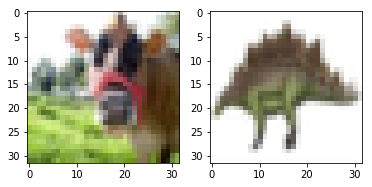

In [4]:
# CIFAR 100 - Setup
(X_train100, y_train100), (X_val100, y_val100) = tf.keras.datasets.cifar100.load_data()
y_train100 = tf.keras.utils.to_categorical(y_train100, 100)
y_val100 = tf.keras.utils.to_categorical(y_val100, 100)

X_train100 = X_train100.reshape(X_train100.shape[0], 32, 32, 3)
X_val100 = X_val100.reshape(X_val100.shape[0], 32, 32, 3)

print('Training data shape', X_train100.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train100[0].reshape(32, 32, 3));
ax2.imshow(X_train100[1].reshape(32, 32, 3));

In [6]:
# Train model on cifar 100
model100 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(100, activation='softmax')
])

model100.compile(optimizer=tf.train.AdamOptimizer(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model100.summary()
hist = model100.fit(X_train100, y_train100,
                  batch_size=64,
                  epochs=50,
                  verbose=1,
                  validation_data=(X_val100, y_val100))

del model100
clear_session()  # Clear previous model
gc.collect()
tf.reset_default_graph()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 256)         0         
__________

Epoch 41/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0820 - acc: 0.9750 - val_loss: 4.5759 - val_acc: 0.4018
Epoch 42/50
50000/50000 [==============================] - 23s 467us/step - loss: 0.0792 - acc: 0.9760 - val_loss: 4.4488 - val_acc: 0.4050
Epoch 43/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0810 - acc: 0.9750 - val_loss: 4.4613 - val_acc: 0.3998
Epoch 44/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0826 - acc: 0.9752 - val_loss: 4.4925 - val_acc: 0.4010
Epoch 45/50
50000/50000 [==============================] - 24s 473us/step - loss: 0.0765 - acc: 0.9764 - val_loss: 4.5700 - val_acc: 0.4011
Epoch 46/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0773 - acc: 0.9762 - val_loss: 4.4530 - val_acc: 0.4000
Epoch 47/50
50000/50000 [==============================] - 23s 467us/step - loss: 0.0738 - acc: 0.9778 - val_loss: 4.7323 - val_acc: 0.4052
Epoch 48/50
50000/50

In [7]:
# Predict and get accuracy
cifar100_accu = hist.history['val_acc'][-1]
print('Accuracy of VGG-A on cifar100: ' + str(cifar100_accu*100) + '%')

Accuracy of VGG-A on cifar100: 40.42%


###### The extremely high training accuracy (~99% for cifar-10 and ~98% for cifar-100) and the low validation accuracy (~75% for cifar-10 and ~40% for cifar-100) show that the VGG-A model severely overfits both cifar-10 and -100 data.

### Examine how many cn layer we can remove before accuracy drops by 2%

In [4]:
# Modify layers toward the input (convolutional layer)
def modified_cn_vggA(X_train, y_train, X_val, y_val, layers, compa, ini_filter=64, input_shape=(32, 32, 3), 
                  classes=10, epoch=5, batch_size=64, early_stop=True, verbose=1):
    
    params_count, min_val_loss, min_val_acc = [], [], []
    for i in range(layers, 0, -1):  # Number of layers is decremented to see at which # of layers, accuracy will drop by 2%
        clear_session()
        
        if early_stop:
            es = EarlyStopping(restore_best_weights=True)
            
        model = tf.keras.Sequential()
        
        model.add(tf.keras.layers.Conv2D(ini_filter, (3,3), padding='same', activation='relu', input_shape=input_shape))
        model.add(tf.keras.layers.MaxPool2D(padding='same'))
        
        if i>7:
            model.add(tf.keras.layers.Conv2D(ini_filter*2, (3,3), padding='same', activation='relu'))
            model.add(tf.keras.layers.MaxPool2D(padding='same'))

        if i>6:
            model.add(tf.keras.layers.Conv2D(ini_filter*4, (3,3), padding='same', activation='relu'))
        if i>5:
            model.add(tf.keras.layers.Conv2D(ini_filter*4, (3,3), padding='same', activation='relu'))
            model.add(tf.keras.layers.MaxPool2D(padding='same'))

        if i>4:
            model.add(tf.keras.layers.Conv2D(ini_filter*8, (3,3), padding='same', activation='relu'))
        if i>3:
            model.add(tf.keras.layers.Conv2D(ini_filter*8, (3,3), padding='same', activation='relu'))
            model.add(tf.keras.layers.MaxPool2D(padding='same'))
            
        if i>2:
            model.add(tf.keras.layers.Conv2D(ini_filter*8, (3,3), padding='same', activation='relu'))
        if i>1:
            model.add(tf.keras.layers.Conv2D(ini_filter*8, (3,3), padding='same', activation='relu'))
            model.add(tf.keras.layers.MaxPool2D(padding='same'))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(4096, activation='relu'))
        model.add(tf.keras.layers.Dense(4096, activation='relu'))
        model.add(tf.keras.layers.Dense(classes, activation='softmax'))

        model.compile(optimizer=tf.train.AdamOptimizer(0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()
        
        # Count param
        params_count.append(model.count_params())
        
        if early_stop:
            hist = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=epoch,
                  verbose=verbose,
                  callbacks=[es],
                  validation_data=(X_val, y_val))
        else: 
            hist = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=epoch,
                  verbose=verbose,
                  validation_data=(X_val, y_val))
        
        if compa-hist.history['val_acc'][-1]>0.02:
            print('At ' + str(layers) + ' layers and ' + str(ini_filter) + ' initial filters, accuracy starts to drop by more than 2%')
        
        curr_l = hist.history['val_loss']
        min_val_loss.append(curr_l[-1])
        min_val_acc.append(hist.history['val_acc'][-1])
        
        del model
    return params_count, min_val_loss, min_val_acc

In [5]:
# For cifar10
layers = 7  # Maximum amount of cn layers is 7
cifar10_accu = 0.752
params_count_layer10, min_val_loss_layer10, _ = modified_cn_vggA(X_train10, y_train10, X_val10, y_val10, layers, ini_filter=64, 
                                              input_shape=(32, 32, 3), classes=10, epoch=50, batch_size=64, 
                                              early_stop=False, verbose=1, compa=cifar10_accu)

# Save the results to .txt file so we don't have to re-train the model
np.savetxt(r"cn_cifar10" + ".txt", np.asmatrix([params_count_layer10, min_val_loss_layer10]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       147712    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         1180160   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         2359808   
__________

50000/50000 [==============================] - 30s 603us/step - loss: 0.0165 - acc: 0.9954 - val_loss: 1.6361 - val_acc: 0.7851
Epoch 35/50
50000/50000 [==============================] - 30s 609us/step - loss: 0.0116 - acc: 0.9966 - val_loss: 1.7360 - val_acc: 0.7717
Epoch 36/50
50000/50000 [==============================] - 30s 607us/step - loss: 0.0164 - acc: 0.9952 - val_loss: 1.4180 - val_acc: 0.7729
Epoch 37/50
50000/50000 [==============================] - 30s 606us/step - loss: 0.0144 - acc: 0.9960 - val_loss: 1.6174 - val_acc: 0.7812
Epoch 38/50
50000/50000 [==============================] - 30s 609us/step - loss: 0.0154 - acc: 0.9956 - val_loss: 1.4592 - val_acc: 0.7816
Epoch 39/50
50000/50000 [==============================] - 31s 612us/step - loss: 0.0196 - acc: 0.9945 - val_loss: 1.3665 - val_acc: 0.7823
Epoch 40/50
50000/50000 [==============================] - 30s 610us/step - loss: 0.0105 - acc: 0.9968 - val_loss: 1.5807 - val_acc: 0.7848
Epoch 41/50
50000/50000 [=======

50000/50000 [==============================] - 31s 610us/step - loss: 0.0076 - acc: 0.9980 - val_loss: 1.6405 - val_acc: 0.7895
Epoch 24/50
50000/50000 [==============================] - 30s 604us/step - loss: 0.0050 - acc: 0.9987 - val_loss: 1.5903 - val_acc: 0.7899
Epoch 25/50
50000/50000 [==============================] - 30s 604us/step - loss: 0.0078 - acc: 0.9979 - val_loss: 1.7425 - val_acc: 0.7822
Epoch 26/50
50000/50000 [==============================] - 30s 607us/step - loss: 0.0104 - acc: 0.9973 - val_loss: 1.5782 - val_acc: 0.7957
Epoch 27/50
50000/50000 [==============================] - 30s 609us/step - loss: 0.0095 - acc: 0.9975 - val_loss: 1.9834 - val_acc: 0.7775
Epoch 28/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0078 - acc: 0.9978 - val_loss: 1.8969 - val_acc: 0.7843
Epoch 29/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0094 - acc: 0.9973 - val_loss: 1.6366 - val_acc: 0.7853
Epoch 30/50
50000/50000 [=======

50000/50000 [==============================] - 31s 612us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 18/50
50000/50000 [==============================] - 30s 607us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 19/50
50000/50000 [==============================] - 30s 606us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 20/50
50000/50000 [==============================] - 30s 610us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 21/50
50000/50000 [==============================] - 31s 613us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 22/50
50000/50000 [==============================] - 30s 609us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 23/50
50000/50000 [==============================] - 30s 609us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoc

Epoch 16/50
50000/50000 [==============================] - 30s 607us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 17/50
50000/50000 [==============================] - 30s 609us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 18/50
50000/50000 [==============================] - 31s 613us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 19/50
50000/50000 [==============================] - 30s 608us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 20/50
50000/50000 [==============================] - 30s 608us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 21/50
50000/50000 [==============================] - 30s 609us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc: 0.8003
Epoch 22/50
50000/50000 [==============================] - 30s 609us/step - loss: 3.2248e-04 - acc: 1.0000 - val_loss: 2.4548 - val_acc:

In [5]:
# For cifar100
cifar100_accu = 0.4042
layers = 7
params_count_layer100, min_val_loss_layer100, min_val_acc100 = modified_cn_vggA(X_train100, y_train100, X_val100, y_val100, layers, ini_filter=64, 
                                              input_shape=(32, 32, 3), classes=100, epoch=50, batch_size=64, 
                                              early_stop=False, verbose=1, compa=cifar100_accu)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       147712    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         1180160   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         2359808   
__________

50000/50000 [==============================] - 30s 604us/step - loss: 0.0293 - acc: 0.9909 - val_loss: 5.5436 - val_acc: 0.4313
Epoch 35/50
50000/50000 [==============================] - 30s 605us/step - loss: 0.0266 - acc: 0.9923 - val_loss: 5.4405 - val_acc: 0.4308
Epoch 36/50
50000/50000 [==============================] - 30s 606us/step - loss: 0.0405 - acc: 0.9890 - val_loss: 5.2253 - val_acc: 0.4314
Epoch 37/50
50000/50000 [==============================] - 30s 610us/step - loss: 0.0361 - acc: 0.9909 - val_loss: 5.3885 - val_acc: 0.4284
Epoch 38/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0299 - acc: 0.9915 - val_loss: 5.3311 - val_acc: 0.4362
Epoch 39/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0324 - acc: 0.9909 - val_loss: 5.3444 - val_acc: 0.4288
Epoch 40/50
50000/50000 [==============================] - 30s 606us/step - loss: 0.0237 - acc: 0.9933 - val_loss: 5.5621 - val_acc: 0.4236
Epoch 41/50
50000/50000 [=======

50000/50000 [==============================] - 30s 607us/step - loss: 0.0235 - acc: 0.9943 - val_loss: 6.5630 - val_acc: 0.4234
Epoch 24/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0309 - acc: 0.9925 - val_loss: 6.4714 - val_acc: 0.4163
Epoch 25/50
50000/50000 [==============================] - 30s 605us/step - loss: 0.0278 - acc: 0.9933 - val_loss: 6.1971 - val_acc: 0.4261
Epoch 26/50
50000/50000 [==============================] - 30s 605us/step - loss: 0.0203 - acc: 0.9946 - val_loss: 6.2103 - val_acc: 0.4254
Epoch 27/50
50000/50000 [==============================] - 30s 607us/step - loss: 0.0290 - acc: 0.9927 - val_loss: 6.1531 - val_acc: 0.4257
Epoch 28/50
50000/50000 [==============================] - 30s 609us/step - loss: 0.0243 - acc: 0.9939 - val_loss: 6.3210 - val_acc: 0.4255
Epoch 29/50
50000/50000 [==============================] - 30s 606us/step - loss: 0.0227 - acc: 0.9945 - val_loss: 6.5785 - val_acc: 0.4247
Epoch 30/50
50000/50000 [=======

50000/50000 [==============================] - 30s 608us/step - loss: 0.0358 - acc: 0.9936 - val_loss: 7.5529 - val_acc: 0.4244
Epoch 19/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0370 - acc: 0.9934 - val_loss: 7.4997 - val_acc: 0.4256
Epoch 20/50
50000/50000 [==============================] - 30s 606us/step - loss: 0.0354 - acc: 0.9936 - val_loss: 7.3749 - val_acc: 0.4257
Epoch 21/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0349 - acc: 0.9941 - val_loss: 7.4262 - val_acc: 0.4202
Epoch 22/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0332 - acc: 0.9937 - val_loss: 7.5520 - val_acc: 0.4234
Epoch 23/50
50000/50000 [==============================] - 30s 608us/step - loss: 0.0308 - acc: 0.9940 - val_loss: 7.4780 - val_acc: 0.4075
Epoch 24/50
50000/50000 [==============================] - 30s 606us/step - loss: 0.0383 - acc: 0.9930 - val_loss: 7.5457 - val_acc: 0.4258
Epoch 25/50
50000/50000 [=======

In [6]:
np.savetxt(r"cn_cifar100" + ".txt", np.asmatrix([params_count_layer100, min_val_loss_layer100, min_val_acc100]))

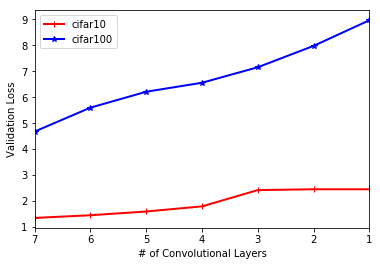

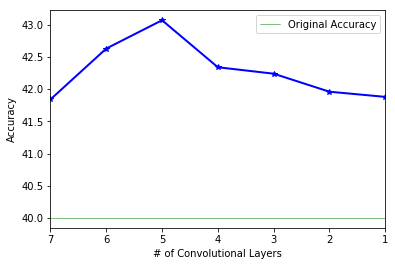

In [33]:
params_count_layer10, min_val_loss_layer10 = np.loadtxt("cn_cifar10.txt")
params_count_layer100, min_val_loss_layer100, min_val_acc100 = np.loadtxt('cn_cifar100.txt')

layers = 7
layer_range = range(layers, 0, -1)
cifar100_bar = np.copy(layer_range)
cifar100_bar[:] = 40.42

plt.plot(layer_range, min_val_loss_layer10, "r-+", linewidth=2)
plt.plot(layer_range, min_val_loss_layer100, "b-*", linewidth=2)
plt.legend(['cifar10', 'cifar100'])
plt.xlabel('# of Convolutional Layers')
plt.ylabel('Validation Loss')
plt.xlim([layer_range[0], layer_range[-1]])
plt.show()

plt.plot(layer_range, cifar100_bar, "g", linewidth=0.5)
plt.plot(layer_range, min_val_acc100*100, "b-*", linewidth=2)
plt.xlabel('# of Convolutional Layers')
plt.ylabel('Accuracy')
plt.legend(['Original Accuracy'])
plt.xlim([layer_range[0], layer_range[-1]])
plt.show()

###### By removing top 3 convolutional layers toward the input, our accuracy is improved by ~3% on cifar-100 data, proving that the full model was overfitting. However, it is a better idea to remove filters toward output at the fully-connected layers (FCN) because convolutional layers are for extracting the meaningful features.

### Examine how many fcn filters we can remove until accuracy drops by 2%

In [5]:
# Modify layers toward the output (dense layer)
def modified_fcn_vggA(X_train, y_train, X_val, y_val, compa, decrement=500, input_shape=(32, 32, 3), 
                  classes=10, epoch=5, batch_size=64, early_stop=True, verbose=1, lr=0.0001, ini_filter=64):
    
    params_count, min_val_loss, min_val_acc = [], [], []
    for i in range(4096-500, 596, -decrement):  # Number of layers is decremented to see at which # of layers, accuracy will drop by 2%
        clear_session()
        
        if early_stop:
            es = EarlyStopping(restore_best_weights=True)
            
        model = tf.keras.Sequential()
        
        model.add(tf.keras.layers.Conv2D(ini_filter, (3,3), padding='same', activation='relu', input_shape=input_shape))
        model.add(tf.keras.layers.MaxPool2D(padding='same'))
        
        model.add(tf.keras.layers.Conv2D(ini_filter*2, (3,3), padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(padding='same'))

        model.add(tf.keras.layers.Conv2D(ini_filter*4, (3,3), padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(ini_filter*4, (3,3), padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(padding='same'))

        model.add(tf.keras.layers.Conv2D(ini_filter*8, (3,3), padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(ini_filter*8, (3,3), padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(padding='same'))

        model.add(tf.keras.layers.Conv2D(ini_filter*8, (3,3), padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(ini_filter*8, (3,3), padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(padding='same'))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(i, activation='relu'))
        model.add(tf.keras.layers.Dense(i, activation='relu'))
        model.add(tf.keras.layers.Dense(classes, activation='softmax'))

        model.compile(optimizer=tf.train.AdamOptimizer(lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()
        
        # Count param
        params_count.append(i)
        
        if early_stop:
            hist = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=epoch,
                  verbose=verbose,
                  callbacks=[es],
                  validation_data=(X_val, y_val))
        else: 
            hist = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=epoch,
                  verbose=verbose,
                  validation_data=(X_val, y_val))
        
        # Compare accuracy with full model to check if it drops below 2%
        if compa-hist.history['val_acc'][-1]>0.02:
            print('At ' + str(i) + ' filters in fcn layers, accuracy starts to drop by more than 2%')
        
        curr_l = hist.history['val_loss']
        min_val_loss.append(curr_l[-1])
        min_val_acc.append(hist.history['val_acc'][-1])
    return params_count, min_val_loss, min_val_acc

In [20]:
# The # of filters is decremented from 4096 to 1096, with input 'decrement' as the step size
cifar10_accu = 0.752
decrement = 500
params_count_layer10, min_val_loss_layer10, min_val_acc10 = modified_fcn_vggA(X_train10, y_train10, X_val10, y_val10, 
                                                                              decrement=decrement, 
                                              input_shape=(32, 32, 3), classes=10, epoch=50, batch_size=64, 
                                              early_stop=False, verbose=1, compa=cifar10_accu)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
__________

Epoch 41/50
50000/50000 [==============================] - 23s 459us/step - loss: 0.0265 - acc: 0.9922 - val_loss: 1.3555 - val_acc: 0.7440
Epoch 42/50
50000/50000 [==============================] - 23s 459us/step - loss: 0.0273 - acc: 0.9920 - val_loss: 1.6376 - val_acc: 0.7509
Epoch 43/50
50000/50000 [==============================] - 23s 454us/step - loss: 0.0209 - acc: 0.9937 - val_loss: 1.5991 - val_acc: 0.7566
Epoch 44/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.0255 - acc: 0.9920 - val_loss: 1.4731 - val_acc: 0.7542
Epoch 45/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.0181 - acc: 0.9942 - val_loss: 1.7080 - val_acc: 0.7560
Epoch 46/50
50000/50000 [==============================] - 23s 460us/step - loss: 0.0248 - acc: 0.9924 - val_loss: 1.5873 - val_acc: 0.7596
Epoch 47/50
50000/50000 [==============================] - 23s 454us/step - loss: 0.0264 - acc: 0.9924 - val_loss: 1.5953 - val_acc: 0.7512
Epoch 48/50
50000/50

Epoch 31/50
50000/50000 [==============================] - 22s 447us/step - loss: 0.0149 - acc: 0.9960 - val_loss: 1.6537 - val_acc: 0.7672
Epoch 32/50
50000/50000 [==============================] - 22s 450us/step - loss: 0.0165 - acc: 0.9957 - val_loss: 1.4710 - val_acc: 0.7620
Epoch 33/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.0163 - acc: 0.9955 - val_loss: 1.7367 - val_acc: 0.7518
Epoch 34/50
50000/50000 [==============================] - 22s 448us/step - loss: 0.0143 - acc: 0.9961 - val_loss: 1.6538 - val_acc: 0.7678
Epoch 35/50
50000/50000 [==============================] - 22s 447us/step - loss: 0.0155 - acc: 0.9957 - val_loss: 1.7360 - val_acc: 0.7580
Epoch 36/50
50000/50000 [==============================] - 22s 449us/step - loss: 0.0118 - acc: 0.9965 - val_loss: 1.5516 - val_acc: 0.7603
Epoch 37/50
50000/50000 [==============================] - 23s 450us/step - loss: 0.0194 - acc: 0.9942 - val_loss: 1.6792 - val_acc: 0.7689
Epoch 38/50
50000/50

50000/50000 [==============================] - 23s 455us/step - loss: 0.0099 - acc: 0.9978 - val_loss: 1.7550 - val_acc: 0.7635
Epoch 10/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.0027 - acc: 0.9993 - val_loss: 2.0431 - val_acc: 0.7680
Epoch 11/50
50000/50000 [==============================] - 23s 452us/step - loss: 0.0085 - acc: 0.9977 - val_loss: 1.8484 - val_acc: 0.7683
Epoch 12/50
50000/50000 [==============================] - 22s 449us/step - loss: 0.0037 - acc: 0.9991 - val_loss: 2.0127 - val_acc: 0.7755
Epoch 13/50
50000/50000 [==============================] - 22s 449us/step - loss: 0.0137 - acc: 0.9965 - val_loss: 1.5276 - val_acc: 0.7681
Epoch 14/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.0066 - acc: 0.9980 - val_loss: 1.8725 - val_acc: 0.7604
Epoch 15/50
50000/50000 [==============================] - 23s 451us/step - loss: 0.0093 - acc: 0.9972 - val_loss: 1.9119 - val_acc: 0.7704
Epoch 16/50
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 23s 457us/step - loss: 0.0061 - acc: 0.9983 - val_loss: 1.8313 - val_acc: 0.7664
Epoch 2/50
50000/50000 [==============================] - 23s 452us/step - loss: 0.0152 - acc: 0.9963 - val_loss: 1.7932 - val_acc: 0.7727
Epoch 3/50
50000/50000 [==============================] - 23s 450us/step - loss: 0.0079 - acc: 0.9980 - val_loss: 1.7672 - val_acc: 0.7678
Epoch 4/50
50000/50000 [==============================] - 23s 452us/step - loss: 0.0077 - acc: 0.9980 - val_loss: 1.9605 - val_acc: 0.7682
Epoch 5/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.0089 - acc: 0.9973 - val_loss: 2.0166 - val_acc: 0.7721
Epoch 6/50
50000/50000 [==============================] - 23s 454us/step - loss: 0.0081 - acc: 0.9978 - val_loss: 1.8716 - val_acc: 0.7754
Epoch 7/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.0083 - acc: 0.9977 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 23s 456us/step - loss: 0.0117 - acc: 0.9971 - val_loss: 1.6333 - val_acc: 0.7653
Epoch 2/50
50000/50000 [==============================] - 23s 451us/step - loss: 0.0071 - acc: 0.9981 - val_loss: 1.8811 - val_acc: 0.7726
Epoch 3/50
50000/50000 [==============================] - 23s 452us/step - loss: 0.0090 - acc: 0.9977 - val_loss: 1.6374 - val_acc: 0.7682
Epoch 4/50
50000/50000 [==============================] - 23s 460us/step - loss: 0.0091 - acc: 0.9976 - val_loss: 1.7714 - val_acc: 0.7725
Epoch 5/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.0076 - acc: 0.9981 - val_loss: 1.7321 - val_acc: 0.7760
Epoch 6/50
50000/50000 [==============================] - 22s 445us/step - loss: 0.0048 - acc: 0.9988 - val_loss: 1.8639 - val_acc: 0.7753
Epoch 7/50
50000/50000 [==============================] - 22s 444us/step - loss: 0.0089 - acc: 0.9978 - val_loss: 1.

In [21]:
# Save the results so we don't have to re-train
np.savetxt(r"fcn_cifar10" + ".txt", np.asmatrix([params_count_layer10, min_val_loss_layer10, min_val_acc10]))

In [6]:
cifar100_accu = 0.4042
params_count_layer100, min_val_loss_layer100, min_val_acc100 = modified_fcn_vggA(X_train100, y_train100, X_val100, y_val100, decrement=500,
                                              input_shape=(32, 32, 3), classes=100, epoch=50, batch_size=64, 
                                              early_stop=False, verbose=1, compa=cifar100_accu)

np.savetxt(r"fcn_cifar100" + ".txt", np.asmatrix([params_count_layer100, min_val_loss_layer100, min_val_acc100]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
__________

Epoch 41/50
50000/50000 [==============================] - 23s 458us/step - loss: 0.0789 - acc: 0.9762 - val_loss: 4.6636 - val_acc: 0.3902
Epoch 42/50
50000/50000 [==============================] - 23s 454us/step - loss: 0.0833 - acc: 0.9755 - val_loss: 4.7275 - val_acc: 0.3930
Epoch 43/50
50000/50000 [==============================] - 23s 457us/step - loss: 0.0806 - acc: 0.9749 - val_loss: 4.6053 - val_acc: 0.3938
Epoch 44/50
50000/50000 [==============================] - 23s 457us/step - loss: 0.0758 - acc: 0.9781 - val_loss: 4.7149 - val_acc: 0.3813
Epoch 45/50
50000/50000 [==============================] - 23s 457us/step - loss: 0.0780 - acc: 0.9764 - val_loss: 4.6241 - val_acc: 0.3934
Epoch 46/50
50000/50000 [==============================] - 23s 459us/step - loss: 0.0770 - acc: 0.9770 - val_loss: 4.7492 - val_acc: 0.3937
Epoch 47/50
50000/50000 [==============================] - 23s 458us/step - loss: 0.0699 - acc: 0.9790 - val_loss: 4.8154 - val_acc: 0.3843
Epoch 48/50
50000/50

Epoch 31/50
50000/50000 [==============================] - 23s 462us/step - loss: 0.0509 - acc: 0.9852 - val_loss: 4.7040 - val_acc: 0.3997
Epoch 32/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0613 - acc: 0.9827 - val_loss: 4.6036 - val_acc: 0.4005
Epoch 33/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0402 - acc: 0.9879 - val_loss: 4.8141 - val_acc: 0.3911
Epoch 34/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0568 - acc: 0.9842 - val_loss: 4.7160 - val_acc: 0.4077
Epoch 35/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0532 - acc: 0.9853 - val_loss: 4.6455 - val_acc: 0.3996
Epoch 36/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0485 - acc: 0.9858 - val_loss: 4.5476 - val_acc: 0.3975
Epoch 37/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0522 - acc: 0.9851 - val_loss: 4.8510 - val_acc: 0.3955
Epoch 38/50
50000/50

Epoch 21/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0417 - acc: 0.9886 - val_loss: 4.8972 - val_acc: 0.3972
Epoch 22/50
50000/50000 [==============================] - 23s 466us/step - loss: 0.0429 - acc: 0.9883 - val_loss: 4.7710 - val_acc: 0.3969
Epoch 23/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.0472 - acc: 0.9874 - val_loss: 4.9261 - val_acc: 0.3969
Epoch 24/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0404 - acc: 0.9889 - val_loss: 5.0898 - val_acc: 0.3879
Epoch 25/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.0454 - acc: 0.9877 - val_loss: 5.0672 - val_acc: 0.4009
Epoch 26/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0362 - acc: 0.9899 - val_loss: 5.1409 - val_acc: 0.4000
Epoch 27/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0428 - acc: 0.9882 - val_loss: 5.4012 - val_acc: 0.3891
Epoch 28/50
50000/50

Epoch 11/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.0393 - acc: 0.9900 - val_loss: 5.1637 - val_acc: 0.4067
Epoch 12/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0445 - acc: 0.9883 - val_loss: 5.1425 - val_acc: 0.3933
Epoch 13/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0411 - acc: 0.9898 - val_loss: 4.7192 - val_acc: 0.4063
Epoch 14/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0217 - acc: 0.9941 - val_loss: 5.2359 - val_acc: 0.4043
Epoch 15/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0468 - acc: 0.9878 - val_loss: 4.6807 - val_acc: 0.3992
Epoch 16/50
50000/50000 [==============================] - 23s 466us/step - loss: 0.0303 - acc: 0.9926 - val_loss: 5.2413 - val_acc: 0.3992
Epoch 17/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0475 - acc: 0.9884 - val_loss: 5.0327 - val_acc: 0.3949
Epoch 18/50
50000/50

50000/50000 [==============================] - 24s 470us/step - loss: 0.0300 - acc: 0.9925 - val_loss: 5.3646 - val_acc: 0.4020
Epoch 2/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.0410 - acc: 0.9902 - val_loss: 5.2426 - val_acc: 0.4013
Epoch 3/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0341 - acc: 0.9917 - val_loss: 5.2690 - val_acc: 0.3976
Epoch 4/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0328 - acc: 0.9925 - val_loss: 4.9334 - val_acc: 0.3980
Epoch 5/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0438 - acc: 0.9901 - val_loss: 5.1336 - val_acc: 0.4006
Epoch 6/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.0371 - acc: 0.9912 - val_loss: 5.2267 - val_acc: 0.3978
Epoch 7/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.0427 - acc: 0.9898 - val_loss: 4.8196 - val_acc: 0.4077
Epoch 8/50
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0310 - acc: 0.9928 - val_loss: 5.1244 - val_acc: 0.3958
Epoch 2/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.0335 - acc: 0.9920 - val_loss: 5.1980 - val_acc: 0.4033
Epoch 3/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.0301 - acc: 0.9925 - val_loss: 5.1978 - val_acc: 0.4008
Epoch 4/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0298 - acc: 0.9937 - val_loss: 5.1171 - val_acc: 0.3985
Epoch 5/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0363 - acc: 0.9916 - val_loss: 5.2606 - val_acc: 0.3917
Epoch 6/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0306 - acc: 0.9934 - val_loss: 5.0754 - val_acc: 0.4014
Epoch 7/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.0271 - acc: 0.9939 - val_loss: 5.

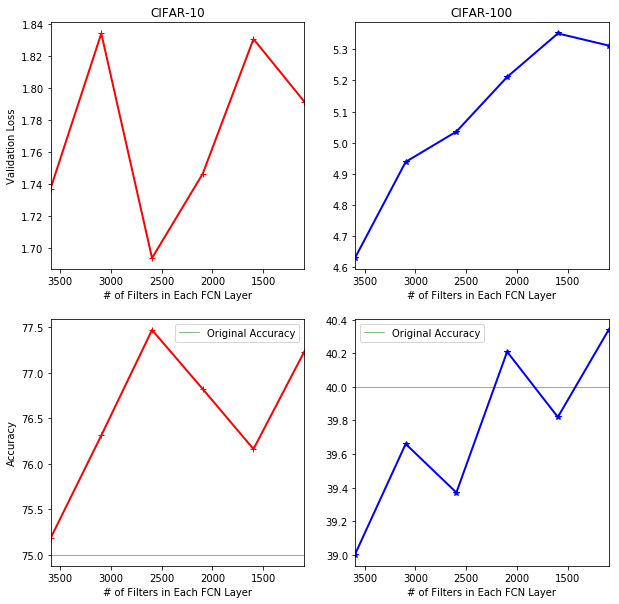

In [34]:
params_count_layer10, min_val_loss_layer10, min_val_acc10 = np.loadtxt("fcn_cifar10.txt")
params_count_layer100, min_val_loss_layer100, min_val_acc100 = np.loadtxt('fcn_cifar100.txt')


# Plot out the results
filter_range = range(4096-500, 596, -500)

cifar10_bar = np.copy(filter_range)
cifar10_bar[:] = 75.2
cifar100_bar = np.copy(filter_range)
cifar100_bar[:] = 40.42

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
ax.set_title("CIFAR-10")
h = plt.plot(filter_range, min_val_loss_layer10, "r-+", linewidth=2)
plt.xlabel('# of Filters in Each FCN Layer')
plt.ylabel('Validation Loss')
plt.xlim([filter_range[0], filter_range[-1]])
ax = fig.add_subplot(2, 2, 2)
ax.set_title("CIFAR-100")
h = plt.plot(filter_range, min_val_loss_layer100, "b-*", linewidth=2)
plt.xlabel('# of Filters in Each FCN Layer')
plt.xlim([filter_range[0], filter_range[-1]])
ax = fig.add_subplot(2, 2, 3)
h = plt.plot(filter_range, cifar10_bar, "g", linewidth=0.5)
h = plt.plot(filter_range, min_val_acc10*100, "r-+", linewidth=2)
plt.legend(['Original Accuracy'])
plt.xlabel('# of Filters in Each FCN Layer')
plt.ylabel('Accuracy')
plt.xlim([filter_range[0], filter_range[-1]])
ax = fig.add_subplot(2, 2, 4)
h = plt.plot(filter_range, cifar100_bar, "g", linewidth=0.5)
h = plt.plot(filter_range, min_val_acc100*100, "b-*", linewidth=2)
plt.legend(['Original Accuracy'])
plt.xlabel('# of Filters in Each FCN Layer')
plt.xlim([filter_range[0], filter_range[-1]])
plt.show()

###### Opposed to our speculation, it turns out that removing the convolutional layers will improve the model more than removing the FCN layers. In these figures, even though the model is less overfitting than the original one, the improvement in accuracy is not as clear as when we remove convolutional layers.

# (Optional) Part 4, state of the art

Currently, state of the art implementations in the image classification problem are DenseNet: (https://arxiv.org/abs/1608.06993), ResNet (https://arxiv.org/abs/1512.03385), and ResNext (https://arxiv.org/pdf/1611.05431.pdf). Try implementing and training one of these on the cifar10 and cifar100 dataset. Feel free to experiment.

Jargon to learn about
1. What is "residual learning"?
2. What is a "bottleneck layer"?
3. What is a "dense block"?